In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN

plt.style.use('ggplot')

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,
from keras.optimizers import SGD, Adam,RMSprop
from keras.utils import np_utils

Using TensorFlow backend.


In [170]:
clf = Sequential([
    Dense(units=64, kernel_initializer='uniform', input_dim=63, activation='relu'),
    Dense(units=1024, kernel_initializer='uniform',activation='relu'),
    Dropout(0.3),
    Dense(units=512, kernel_initializer='uniform',activation='relu'),
    Dropout(0.3),
    Dense(units=64, kernel_initializer='uniform',activation='relu'),
    Dense(1, kernel_initializer='uniform', activation='sigmoid')
])
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 64)                4096      
_________________________________________________________________
dense_93 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dropout_26 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_94 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 65        
Total para

In [171]:
from sklearn.metrics import roc_curve, auc
from keras import backend as K  

def ant_score(y_true, y_pred):  
    fpr, tpr, thresholds = roc_curve(y_true,y_pred)
    roc_auc = auc(fpr, tpr)
    roc_result = pd.DataFrame()
    roc_result['fpr'] = pd.Series(fpr)
    roc_result['tpr'] = pd.Series(tpr)
    roc_result['thresholds'] = pd.Series(thresholds)
    TPR1= float(roc_result[roc_result['fpr']<=0.001002].tail(1)['tpr'])
    TPR2=float(roc_result[roc_result['fpr']<=0.005002].tail(1)['tpr'])
    TPR3=float(roc_result[roc_result['fpr']<=0.010002].tail(1)['tpr'])
    FINAL_SCORE = 0.4*TPR1 + 0.3*TPR2 + 0.3 * TPR3 
    return FINAL_SCORE

def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):  
    y_pred = K.cast(y_pred >= threshold, 'float32')  
    # N = total number of negative labels  
    N = K.sum(1 - y_true)  
    # FP = total number of false alerts, alerts from the negative class labels  
    FP = K.sum(y_pred - y_pred * y_true)  
    return FP/N  

def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):  
    y_pred = K.cast(y_pred >= threshold, 'float32')  
    # P = total number of positive labels  
    P = K.sum(y_true)  
    # TP = total number of correct alerts, alerts from the positive class labels  
    TP = K.sum(y_pred * y_true)  
    return TP/P 


def auc(y_true, y_pred):  
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)  
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)  
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)  
    binSizes = -(pfas[1:]-pfas[:-1])  
    s = ptas*binSizes  
    return K.sum(s, axis=0)  

clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [154]:
train_proba = pd.read_pickle('./res.dat')
predictors = ['n0', 'mean', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9',
       'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19',
       'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29',
       'n30', 'n31', 'n32', 'n33', 'n34', 'n35', 'n36', 'n37', 'n38', 'n39',
       'n40', 'n41', 'n42', 'n43', 'n44', 'n45', 'n46', 'n47', 'n48', 'n49',
       'n50', 'n51', 'n52', 'n53', 'n54', 'n55', 'n56', 'n57', 'n58', 'n59']

In [156]:
skew = train_proba.T.skew()

In [157]:
kurt = train_proba.T.kurt()

In [166]:
skew = train_proba[predictors].skew(axis=1)
kurt = train_proba[predictors].kurt(axis=1)

In [167]:
train_proba['skew'] = skew
train_proba['kurt'] = kurt

In [168]:
#predictors = [x for x in train_proba2.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]


predictors = ['n0', 'mean', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9',
       'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19',
       'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29',
       'n30', 'n31', 'n32', 'n33', 'n34', 'n35', 'n36', 'n37', 'n38', 'n39',
       'n40', 'n41', 'n42', 'n43', 'n44', 'n45', 'n46', 'n47', 'n48', 'n49',
       'n50', 'n51', 'n52', 'n53', 'n54', 'n55', 'n56', 'n57', 'n58', 'n59','skew','kurt']

target='Fraud'
X_train=train_proba[train_proba['date']<='2017-10-15'][predictors]
y_train=train_proba2[train_proba['date']<='2017-10-15'][target]

X_verify=train_proba[train_proba['date']>'2017-10-15'][predictors]
y_verify=train_proba[train_proba['date']>'2017-10-15'][target]


In [174]:
class_weight = {0: 10.,
                1: 1.
               }

clf.fit(X_train, y_train, batch_size=50, epochs=800)

Epoch 1/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.2148 - acc: 0.9158
Epoch 2/800
36326/36326 [==============================] - 5s 136us/step - loss: 0.1789 - acc: 0.9281
Epoch 3/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.1682 - acc: 0.9313
Epoch 4/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.1657 - acc: 0.9327
Epoch 5/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.1622 - acc: 0.9351
Epoch 6/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.1593 - acc: 0.9345
Epoch 7/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.1569 - acc: 0.9356
Epoch 8/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.1538 - acc: 0.9368
Epoch 9/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.1527 - acc: 0.9367
Epoch 10/800
36326/36326 [==============================] - 5s 135us/step - loss: 

36326/36326 [==============================] - 5s 134us/step - loss: 0.0889 - acc: 0.9622
Epoch 81/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0901 - acc: 0.9611
Epoch 82/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0886 - acc: 0.9619
Epoch 83/800
36326/36326 [==============================] - 5s 136us/step - loss: 0.0905 - acc: 0.9605
Epoch 84/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0862 - acc: 0.9634
Epoch 85/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0888 - acc: 0.9614
Epoch 86/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0932 - acc: 0.9606
Epoch 87/800
36326/36326 [==============================] - 5s 137us/step - loss: 0.0868 - acc: 0.9631
Epoch 88/800
36326/36326 [==============================] - 5s 136us/step - loss: 0.0880 - acc: 0.9617
Epoch 89/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.08

36326/36326 [==============================] - 5s 133us/step - loss: 0.0638 - acc: 0.9728
Epoch 160/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0633 - acc: 0.9741
Epoch 161/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0614 - acc: 0.9740
Epoch 162/800
36326/36326 [==============================] - 5s 132us/step - loss: 0.0665 - acc: 0.9725
Epoch 163/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0647 - acc: 0.9734
Epoch 164/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0614 - acc: 0.9743
Epoch 165/800
36326/36326 [==============================] - 5s 136us/step - loss: 0.0629 - acc: 0.9736
Epoch 166/800
36326/36326 [==============================] - 5s 132us/step - loss: 0.0616 - acc: 0.9742
Epoch 167/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0626 - acc: 0.9728
Epoch 168/800
36326/36326 [==============================] - 5s 135us/step - l

36326/36326 [==============================] - 5s 136us/step - loss: 0.0497 - acc: 0.9793
Epoch 238/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0530 - acc: 0.9783
Epoch 239/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0536 - acc: 0.9781
Epoch 240/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0506 - acc: 0.9797
Epoch 241/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0513 - acc: 0.9795
Epoch 242/800
36326/36326 [==============================] - 5s 133us/step - loss: 0.0494 - acc: 0.9797
Epoch 243/800
36326/36326 [==============================] - 5s 132us/step - loss: 0.0493 - acc: 0.9804
Epoch 244/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0492 - acc: 0.9802
Epoch 245/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0522 - acc: 0.9797
Epoch 246/800
36326/36326 [==============================] - 5s 133us/step - l

36326/36326 [==============================] - 5s 134us/step - loss: 0.0438 - acc: 0.9822
Epoch 316/800
36326/36326 [==============================] - 5s 136us/step - loss: 0.0479 - acc: 0.9813
Epoch 317/800
36326/36326 [==============================] - 5s 133us/step - loss: 0.0449 - acc: 0.9828
Epoch 318/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0416 - acc: 0.9835
Epoch 319/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0501 - acc: 0.9808
Epoch 320/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0409 - acc: 0.9840
Epoch 321/800
36326/36326 [==============================] - 5s 132us/step - loss: 0.0422 - acc: 0.9837
Epoch 322/800
36326/36326 [==============================] - 5s 136us/step - loss: 0.0457 - acc: 0.9821
Epoch 323/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0466 - acc: 0.9823
Epoch 324/800
36326/36326 [==============================] - 5s 136us/step - l

36326/36326 [==============================] - 5s 134us/step - loss: 0.0416 - acc: 0.9841
Epoch 394/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0390 - acc: 0.9845
Epoch 395/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0420 - acc: 0.9839
Epoch 396/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0381 - acc: 0.9852
Epoch 397/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0391 - acc: 0.9847
Epoch 398/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0426 - acc: 0.9836
Epoch 399/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0381 - acc: 0.9845
Epoch 400/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0409 - acc: 0.9843
Epoch 401/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0384 - acc: 0.9852
Epoch 402/800
36326/36326 [==============================] - 5s 135us/step - l

36326/36326 [==============================] - 5s 133us/step - loss: 0.0408 - acc: 0.9846
Epoch 472/800
36326/36326 [==============================] - 5s 136us/step - loss: 0.0342 - acc: 0.9866
Epoch 473/800
36326/36326 [==============================] - 5s 136us/step - loss: 0.0383 - acc: 0.9854
Epoch 474/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0408 - acc: 0.9849
Epoch 475/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0367 - acc: 0.9859
Epoch 476/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0335 - acc: 0.9873
Epoch 477/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0452 - acc: 0.9834
Epoch 478/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0394 - acc: 0.9849
Epoch 479/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0350 - acc: 0.9871
Epoch 480/800
36326/36326 [==============================] - 5s 134us/step - l

36326/36326 [==============================] - 5s 134us/step - loss: 0.0366 - acc: 0.9866
Epoch 550/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0349 - acc: 0.9868
Epoch 551/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0343 - acc: 0.9871
Epoch 552/800
36326/36326 [==============================] - 5s 133us/step - loss: 0.0324 - acc: 0.9881
Epoch 553/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0381 - acc: 0.9863
Epoch 554/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0350 - acc: 0.9867
Epoch 555/800
36326/36326 [==============================] - 5s 136us/step - loss: 0.0367 - acc: 0.9862
Epoch 556/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0412 - acc: 0.9855
Epoch 557/800
36326/36326 [==============================] - 5s 133us/step - loss: 0.0361 - acc: 0.9870
Epoch 558/800
36326/36326 [==============================] - 5s 134us/step - l

36326/36326 [==============================] - 5s 133us/step - loss: 0.0379 - acc: 0.9869
Epoch 628/800
36326/36326 [==============================] - 5s 136us/step - loss: 0.0456 - acc: 0.9847
Epoch 629/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0367 - acc: 0.9865
Epoch 630/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0298 - acc: 0.9891
Epoch 631/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0383 - acc: 0.9856
Epoch 632/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0376 - acc: 0.9873
Epoch 633/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0316 - acc: 0.9890
Epoch 634/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0363 - acc: 0.9875
Epoch 635/800
36326/36326 [==============================] - 5s 132us/step - loss: 0.0541 - acc: 0.9808
Epoch 636/800
36326/36326 [==============================] - 5s 135us/step - l

36326/36326 [==============================] - 5s 134us/step - loss: 0.0316 - acc: 0.9881
Epoch 706/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0299 - acc: 0.9896
Epoch 707/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0361 - acc: 0.9871
Epoch 708/800
36326/36326 [==============================] - 5s 132us/step - loss: 0.0380 - acc: 0.9869
Epoch 709/800
36326/36326 [==============================] - 5s 133us/step - loss: 0.0339 - acc: 0.9883
Epoch 710/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0407 - acc: 0.9861
Epoch 711/800
36326/36326 [==============================] - 5s 133us/step - loss: 0.0354 - acc: 0.9873
Epoch 712/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0332 - acc: 0.9887
Epoch 713/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0357 - acc: 0.9871
Epoch 714/800
36326/36326 [==============================] - 5s 134us/step - l

36326/36326 [==============================] - 5s 135us/step - loss: 0.0332 - acc: 0.9887
Epoch 784/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0322 - acc: 0.9891
Epoch 785/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0304 - acc: 0.9895
Epoch 786/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0322 - acc: 0.9887
Epoch 787/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0344 - acc: 0.9883
Epoch 788/800
36326/36326 [==============================] - 5s 134us/step - loss: 0.0293 - acc: 0.9897
Epoch 789/800
36326/36326 [==============================] - 5s 132us/step - loss: 0.0347 - acc: 0.9881
Epoch 790/800
36326/36326 [==============================] - 5s 135us/step - loss: 0.0342 - acc: 0.9882
Epoch 791/800
36326/36326 [==============================] - 5s 133us/step - loss: 0.0354 - acc: 0.9873
Epoch 792/800
36326/36326 [==============================] - 5s 135us/step - l

In [175]:
y_verify_proba = clf.predict_proba(X_verify)

Ant-Score: 0.01772056039379023


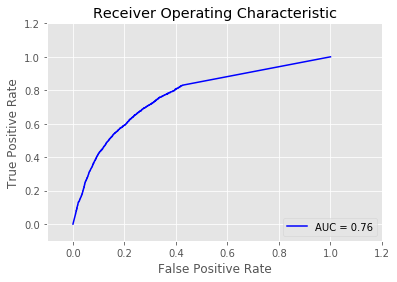

In [176]:
a,b,c=atecml.data.accuracy_validation(y_verify,y_verify_proba)

In [127]:
test_df = atecml.data.load_test()
result_proba = clf.predict_proba(test_proba)


NameError: name 'test_proba' is not defined

In [ ]:
result = pd.DataFrame()
result['id'] =test_df['id']
result['score'] =pd.DataFrame(result_proba)[0]

In [ ]:
result.set_index('id').to_csv('./submit_20180627_1.csv')    